# IoU weighted block F1

* In fact this is exactly [Panoptic Quality](https://medium.com/@danielmechea/panoptic-segmentation-the-panoptic-quality-metric-d69a6c3ace30)

This is a less strict version of block F1. Where in block F1 you only count the exact hits as True Positives, here you connect each predicted block to a unique true block if their IoU is larger than a half.

Now you simply take the sum of all IoU values of those pairs as the numerator in the calculation of Precision and Recall. 

So here you also get "points", namely the IoU for matches which are slightly off.

Note that each predicted block can only be matched to at most one true block.

In the case that all matches are exact, all these IoU's are 1, and we simply have the block measures.


In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
%matplotlib inline

In [2]:
vb_truth, vb_pred = [1,2,1,3,3,5], [1,1,2,3,4,3,1]

def make_index(split):
    l= sum(split)
    pages= list(np.arange(l))
    out = defaultdict(set)
    for block_length in split:
        block= pages[:block_length]
        pages= pages[block_length:]
        for page in block:
            out[page]= set(block)
    return out

#test
make_index(vb_truth)
#tests


defaultdict(set,
            {0: {0},
             1: {1, 2},
             2: {1, 2},
             3: {3},
             4: {4, 5, 6},
             5: {4, 5, 6},
             6: {4, 5, 6},
             7: {7, 8, 9},
             8: {7, 8, 9},
             9: {7, 8, 9},
             10: {10, 11, 12, 13, 14},
             11: {10, 11, 12, 13, 14},
             12: {10, 11, 12, 13, 14},
             13: {10, 11, 12, 13, 14},
             14: {10, 11, 12, 13, 14}})

In [3]:
def IoU_TruePositives(t,h):
    '''A True Positive is a pair h_block, t_block with an IoU>.5.
    This function returns the sum of all IoUs(h_block,t_block) for these bvlocks in t and h,
    and the sets of TPs, FPs and FNs.'''
    def IoU(S,T):
        '''Jaccard similarity between sets S and T'''
        return len(S&T)/len(S|T)
    def get_docs(t):
        '''Get the set of documents (where each document is a set of pagenumbers)'''
        return {frozenset(S) for S in make_index(t).values()}
    def find_match(S,Candidates):
        '''Finds, if it exists,  the unique T in Candidates such that IoU(S,T) >.5'''
        return [T for T in Candidates if IoU(S,T) >.5]
    t,h= get_docs(t), get_docs(h) # switch to set of docs representation
    TP= {(S,find_match(S,t)[0]) for S in h if find_match(S,t)}
    FP= h-{S for (S,_) in TP}
    FN= t- {T for (_,T) in TP} 
    return sum(IoU(S,T) for (S,T) in TP  ), TP, FP, FN 

IoU_TruePositives(vb_truth, vb_pred)

(3.35,
 {(frozenset({4, 5, 6}), frozenset({4, 5, 6})),
  (frozenset({7, 8, 9, 10}), frozenset({7, 8, 9})),
  (frozenset({11, 12, 13}), frozenset({10, 11, 12, 13, 14})),
  (frozenset({0}), frozenset({0}))},
 {frozenset({1}), frozenset({2, 3}), frozenset({14})},
 {frozenset({3}), frozenset({1, 2})})

In [4]:
def IoU_P(t,h):
    return IoU_TruePositives(t,h)[0]/len(h)
def IoU_R(t,h):
    return IoU_TruePositives(t,h)[0]/len(t)
def IoU_F1(t,h):
    P,R= IoU_P(t,h),IoU_R(t,h)
    TPS,TP,FP,FN=  IoU_TruePositives(t,h)
    return 0 if (P+R)==0 else 2*P*R/(P+R) #  TPS/(len(TP)+ .5*(len(FP)+len(FN))) # gives the same answer
     

IoU_P(vb_truth,vb_pred),IoU_R(vb_truth,vb_pred),IoU_F1(vb_truth,vb_pred)

(0.4785714285714286, 0.5583333333333333, 0.5153846153846153)

       IoU_F1 for fixed page baseline of size 2
count                                 75.000000
mean                                   0.074179
std                                    0.105324
min                                    0.000000
25%                                    0.000000
50%                                    0.039474
75%                                    0.098780
max                                    0.500000


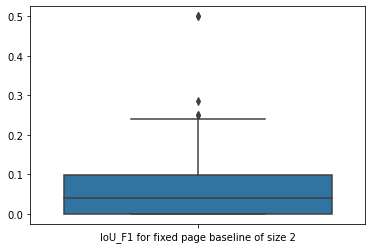

In [5]:
def translate(doclengths):
    if not doclengths:
        return []
    else:
        dl1= doclengths[0]
        return [1]+[0 for _ in range(dl1-1)]+ translate(doclengths[1:])
    
def fixedpage(file,docsize=3):
    number_of_blocks= len(file)//docsize
    rest = len(file) % docsize
    first= [docsize for _ in range(number_of_blocks)]
    if rest !=0:
        return translate(first+[rest])
    else:
        return translate(first )

f= open('Doclengths_of_the_individual_docs.json')
truth_corpus=json.load(f)    
    
D ={pdf: IoU_F1(truth_corpus[pdf], fixedpage(truth_corpus[pdf],2))
   for pdf in truth_corpus}
results= pd.DataFrame.from_dict(D,orient='index')
results.columns=['IoU_F1 for fixed page baseline of size 2']
#print(results.shape)
#print(results.head())
print(results.describe())
sns.boxplot(data=results);